In [1]:
import sys
from source_data import Requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
OUT_FOLDER = r'output_logs/211026104226'

In [2]:
anarray = np.zeros((5,))
listofarrays = [np.array(range(5)) for i in range(3)]

for arr in listofarrays:
    anarray += arr

anarray

array([ 0.,  3.,  6.,  9., 12.])

In [3]:
np.random.randint((5,))

array([0])

In [4]:
# get the model output logs
out_logs = []
for fnm in os.listdir(OUT_FOLDER):
    
    # ignore the computation log
    if fnm[0] != 'c':
        out_logs.append(pd.read_csv(os.path.join(OUT_FOLDER,fnm),dtype=dict(passenger_id=int)))

# concatenate them together
out_df = pd.concat(out_logs).sort_values(['time_stamp']).reset_index(drop=True)

print(out_df.shape)
out_df.head()

# get the min and max times
MINT = out_df['time_stamp'].min()
MAXT = out_df['time_stamp'].max()

(779001, 5)


Check the passengers are only picked up and dropped off once:

In [5]:
np.unique((out_df['passenger_id'].astype(str)+" "+out_df['event']).value_counts().values)

array([1])

In [6]:
# print out the time range
out_df.describe()

,time_stamp,passenger_id,location
count,779001.000000,7.790010e+05,779001.000000
mean,495733.709556,2.125574e+06,1580.055318
std,21494.360503,1.240842e+05,816.757281
min,450030.000000,1.899066e+06,0.000000
25%,477365.000000,2.022356e+06,981.000000
50%,498712.000000,2.126669e+06,1538.000000
75%,513304.000000,2.231902e+06,2183.000000
max,540000.000000,2.342379e+06,4083.000000


In [7]:
# get the requests in the first hour
reqs = Requests().read_requests()
reqs = reqs[(reqs['time']>=MINT)&(reqs['time']<=MAXT)]

# how many hours is this?
print(f"{(MAXT-MINT)/3600:0.1f}")

reqs.head()

25.0


,time,from_node,to_node,window,day,hour,latest_pickup
1899089,450030,1533,1523,15001,5,5,450150
1899090,450031,1213,900,15001,5,5,450151
1899091,450035,2342,1274,15001,5,5,450155
1899092,450039,3158,2183,15001,5,5,450159
1899093,450047,632,277,15001,5,5,450167


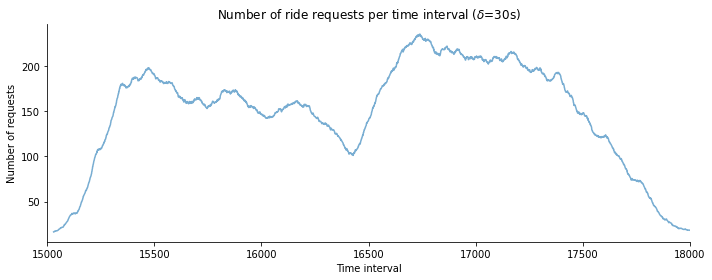

In [8]:
# summarise the requests by hour
numreqs_by_window = reqs.groupby(['window']).\
    agg('count')['time'].\
    rename("num_requests")

# plot a rolling 15 minute average
fig,ax = plt.subplots(figsize=[10,4])
numreqs_by_window.\
    rolling(30).mean().plot(alpha=0.6,ax=ax)

# count the number of request picked up in each window
# numreqs_by_window.plot()
ax.set_title("Number of ride requests per time interval ($\delta$=30s)")
ax.set_ylabel("Number of requests")
ax.set_xlabel("Time interval")
# ax.set_ylim([0,350])
ax.set_xlim([15000,18000])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/numrequests_24.jpg")

In [9]:
# get the timewindows for the pickups
pickups = out_df[out_df['event']=='pickup'].reset_index(drop=True)
pickups = pickups.join(reqs.loc[:,'window'],on=['passenger_id'])
numpicks_by_window = pickups.groupby(['window']).agg('count')['time_stamp'].rename("num_pickups")

# stick it all together
result = pd.concat([numreqs_by_window,numpicks_by_window],axis=1)
result.head()

,num_requests,num_pickups
window,,
15001.0,6,6.0
15002.0,25,25.0
15003.0,5,5.0
15004.0,20,20.0
15005.0,10,10.0


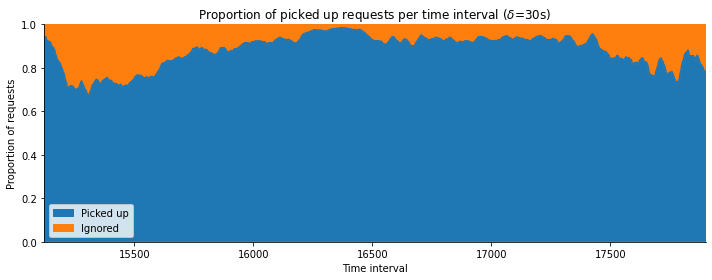

In [10]:
# need to convert to proportion
proportion = result.copy()
proportion['Picked up'] = proportion['num_pickups'] / proportion['num_requests']
proportion['Ignored'] = 1 - proportion['Picked up']

# plot proportion of requests that are picked up
fig,ax = plt.subplots(figsize=[10,4])
ax = proportion.loc[:,['Picked up','Ignored']].rolling(30).mean().plot.area(ax=ax)

# format the plot
ax.set_xlabel("Time interval")
ax.set_ylabel("Proportion of requests")
ax.set_title("Proportion of picked up requests per time interval ($\delta$=30s)")
ax.set_xlim([15120,17900])
ax.set_ylim([0,1])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/rolling_pickedup_24.jpg")

In [11]:
def cab_utilisation(cab_data):
        
    # convert pickup / dropoffs to change in state
    state = cab_data.copy().sort_values(['time_stamp'])
    state['change'] = cab_data['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
    
    # where concurrent events occur, we have sum them to get the net result
    change = state.groupby(['time_stamp'])['change'].agg('sum')
        
    # apply cumsum to get payload load
    payload = np.cumsum(change)
    
    # check if utilised and convert to number  
    utilised = pd.DataFrame((payload > 0).astype(int),index=payload.index).reset_index()
    
    return utilised

# assess whether a cab is utilised or not > 0 passengers
cab_use = []
for cab,data in out_df.groupby(['cab_id']):
    
    cab_util = cab_utilisation(data)
    cab_util['cab_id'] = cab
    cab_use.append(cab_util)
    
cab_use = pd.concat(cab_use,ignore_index=True).rename(columns=dict(change='utilised'))

In [12]:
# create a common time index for all cabs
# its a little bit shorter than all time
time_index = pd.Index(cab_use['time_stamp'].unique(),name="time_index").sort_values()
dummy_col = pd.Series(data=[np.nan]*time_index.shape[0],index=time_index,name='dummy')

def fill_gaps(cab_data):
    
    # add the common index
    cab_data = cab_data.join(dummy_col,on=['time_stamp'],how='right').\
        loc[:,['time_stamp','utilised']].\
        sort_values(['time_stamp']).reset_index(drop=True)
        
    # if the utilisation at time 0 is na then set it to 0
    if cab_data['utilised'].isnull().iloc[0]:
        cab_data.iloc[0,1] = 0
        
    # now fill down to the next state change
    return cab_data.fillna(method='ffill').set_index(['time_stamp'])

utilisations = []
for cab,data in cab_use.groupby(['cab_id']):
    utilisations.append(fill_gaps(data))

In [13]:
utilisations[0].head()

,utilised
time_stamp,
450030,0.0
450034,0.0
450052,0.0
450060,0.0
450084,0.0


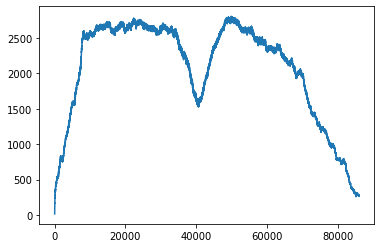

In [14]:
# create a container to add up utilised cabs in each time slot
num_utilised = np.zeros((dummy_col.shape[0],))
for cab_util in utilisations:
    
    num_utilised += cab_util.values.flatten()

plt.plot(num_utilised)

In [15]:
# now caculate the proportion utilised
proportion_utilised = num_utilised / 3000
diff_utilised = 1 - proportion_utilised
to_plot = pd.concat([pd.Series(proportion_utilised,index=time_index),
                     pd.Series(diff_utilised,index=time_index)],axis=1)
to_plot.columns = ["Utilised","Empty"]

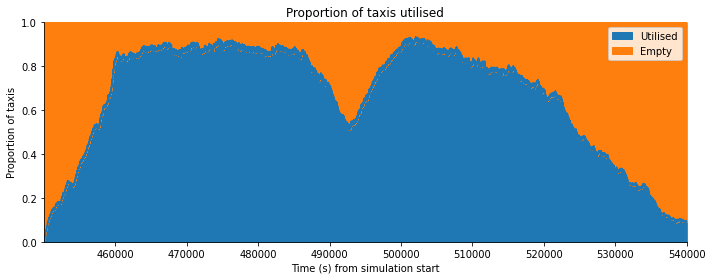

In [16]:
# plot proportion of requests that are picked up
fig,ax = plt.subplots(figsize=[10,4])
ax = to_plot.plot.area(ax=ax)

# format the plot
ax.set_xlabel("Time (s) from simulation start")
ax.set_ylabel("Proportion of taxis")
ax.set_title("Proportion of taxis utilised")
ax.set_ylim([0,1])
ax.set_xlim([MINT,MAXT])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/utilised_cabs24.jpg")

Show computational metrics over the day